In [1]:
requirements_loc = '/kaggle/input/ecen758-proj-requirements-txt/requirements.txt'
!pip install -r {requirements_loc}

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.8 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=6989 sha256=0df7a03bdc33702401db9ecbebd2a2aaf5004e4e3c7670290960168aec7e5dd2
  Stored in directory: /root/.cache/pip/wheels/7f/5c/e6/2c0fdb453a3569188864b17e9676bea8b3b7e160c037117869
Successfully built clip


In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import optuna
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
import seaborn as sns
from sklearn.model_selection import KFold
import os
import clip
import matplotlib.pyplot as plt
import pandas as pd

In [33]:
output_dir = './Images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_dir = './model'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [12]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [13]:
# Define a transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),  
    transforms.Normalize((0.5,), (0.5,)),  # normalize the dataset to range [-1, 1]
    transforms.RandomRotation(10),  # rotate the image randomly by 10 degrees
    transforms.RandomHorizontalFlip() # flip the image horizontally with a 50% probability
    
])

transform_clip = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # normalize the dataset to range [-1, 1]
])

# Download and load the training data
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create indices for training and validation splits
num_train = len(trainset)
indices = list(range(num_train))
np.random.shuffle(indices)

# Define split size
split = int(0.2 * num_train)  # 20% for validation
train_idx, val_idx = indices[split:], indices[:split]

# Create samplers for training and validation
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

# Create data loaders with samplers
trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)

# Download and load the test data
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

testset_clip = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_clip)
testloader_clip = torch.utils.data.DataLoader(testset_clip, batch_size=64, shuffle=False)

In [14]:
# Let's check if our data is loaded correctly
images, labels = next(iter(trainloader))

print(images.shape)
print(len(trainloader))
print(labels.shape)
print(len(testloader))

# Check each sample in the dataset
missing_samples = any(img is None or lbl is None for img, lbl in trainset)

if missing_samples:
    print("Missing data detected in individual samples.")
else:
    print("No missing data found in individual samples.")

torch.Size([64, 1, 28, 28])
750
torch.Size([64])
157
No missing data found in individual samples.


In [15]:
unique_labels, counts = np.unique(trainset.targets, return_counts=True)
print(f"Unique labels: {unique_labels}")
print(f"Counts: {counts}")

print("Number of samples per digit:")
for label, count in zip(unique_labels, counts):
    print(f"Digit {label}: {count}")

# Check if the data distribution is balanced
total_samples = len(trainset.targets)
min_samples = min(counts)
max_samples = max(counts)
balance_ratio = min_samples / max_samples

print(f"\nTotal samples: {total_samples}")
print(f"Balance ratio (min/max): {balance_ratio}")

Unique labels: [0 1 2 3 4 5 6 7 8 9]
Counts: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
Number of samples per digit:
Digit 0: 6000
Digit 1: 6000
Digit 2: 6000
Digit 3: 6000
Digit 4: 6000
Digit 5: 6000
Digit 6: 6000
Digit 7: 6000
Digit 8: 6000
Digit 9: 6000

Total samples: 60000
Balance ratio (min/max): 1.0


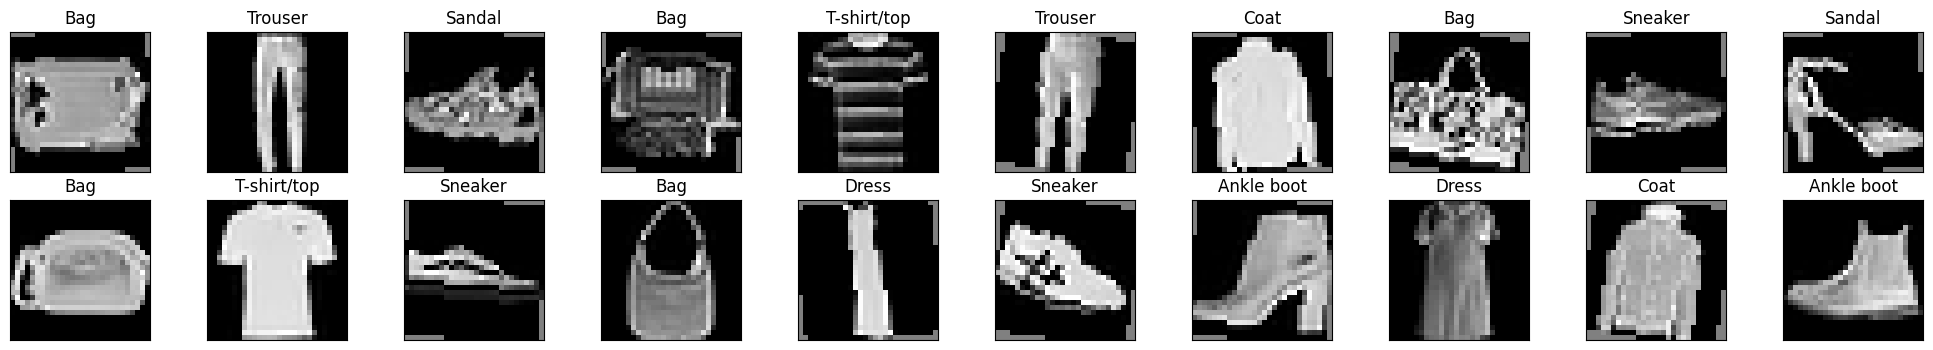

Unique labels plotted successfully


In [16]:
# Let's plot all the unique labels from the dataset
# Define the text labels
text_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title(text_labels[labels[idx].item()])
plt.show()
plt.savefig('./Images/output_image.png')
print("Unique labels plotted successfully")
plt.close()

In [17]:
class SimpleCNNImage(nn.Module):
    def __init__(self, dropout=0.45, kernel_size=3, num_classes=10, flag=True, learning_rate=0.001, num_epochs=10):
        super(SimpleCNNImage, self).__init__()
        self.dropout_rate = dropout
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs

        # If flag is true, then we use grayscale images
        if flag:
            # First Convolutional Layer
            self.conv1 = nn.Conv2d(1, 32, kernel_size=kernel_size, padding=1)
            self.bn1 = nn.BatchNorm2d(32)  # Batch normalization added
            self.relu1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            self.conv1 = nn.Conv2d(3, 32, kernel_size=kernel_size, padding=1)
            self.bn1 = nn.BatchNorm2d(32)
            self.relu1 = nn.ReLU()
            self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Second Convolutional Layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization added
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.bn3 = nn.BatchNorm1d(512)  # Batch normalization added
        self.relu3 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.fc2 = nn.Linear(512, 128)
        self.bn4 = nn.BatchNorm1d(128)  # Batch normalization added
        self.relu4 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Output Layer
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.flatten(x)
        x = self.dropout1(self.relu3(self.bn3(self.fc1(x))))
        x = self.dropout2(self.relu4(self.bn4(self.fc2(x))))
        x1 = x
        x = self.fc3(x)
        return x1, x

In [18]:
# model architecture
model = SimpleCNNImage()
model.to(device)
print(model)

SimpleCNNImage(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (bn3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (dropout1): Dropout(p=0.45, inplace=False)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (dropout2):

In [19]:
model_path = "./model/best_model_state.pth"
best_model = SimpleCNNImage(dropout=0.45).to(device)
criterion = nn.CrossEntropyLoss()

In [26]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10, dropout=0.45, learning_rate=0.001):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            _, outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
        train_losses.append(running_train_loss / len(train_loader))
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        running_valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        
        with torch.no_grad():
            for images, labels in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                _, outputs = model(images)
                loss = criterion(outputs, labels)
                
                running_valid_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()
                
        valid_losses.append(running_valid_loss / len(valid_loader))
        valid_accuracy = 100 * correct_valid / total_valid
        valid_accuracies.append(valid_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Valid Loss: {valid_losses[-1]:.4f}, "
              f"Train Accuracy: {train_accuracy:.2f}%, Valid Accuracy: {valid_accuracy:.2f}%")
    
    # Plotting
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"Training and Validation Loss\n(dropout={dropout}, \n learning_rate={learning_rate}, \n num_epochs={num_epochs})")
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Training and Validation Accuracy\n(dropout={dropout}, \n learning_rate={learning_rate}, \n num_epochs={num_epochs})')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.savefig(f'./Images/loss_accuracy_plot_(dropout={dropout}, learning_rate={learning_rate}, num_epochs={num_epochs}).png')
    print("Loss and accuracy plot saved successfully")
    plt.close()

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [27]:
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters to tune
    dropout = trial.suggest_float('dropout', 0.2, 0.6)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    num_epochs = trial.suggest_int('num_epochs', 5, 20)

    # Initialize the model, criterion, and optimizer with suggested parameters
    model = SimpleCNNImage(dropout=dropout, learning_rate=learning_rate, num_epochs=num_epochs).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Train the model
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        model, criterion, optimizer, trainloader, valloader, num_epochs, dropout, learning_rate
    )

    # Return the best validation accuracy (maximize)
    return max(valid_accuracies)

[I 2024-11-21 23:21:48,537] A new study created in memory with name: no-name-9ebbf89b-23ab-43cc-81ca-dfb6cbac72d3
Epoch 1/8 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.47it/s]


Epoch 1/8, Train Loss: 0.5082, Valid Loss: 0.3524, Train Accuracy: 82.57%, Valid Accuracy: 86.92%


Epoch 2/8 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.83it/s]


Epoch 2/8, Train Loss: 0.3567, Valid Loss: 0.2978, Train Accuracy: 87.32%, Valid Accuracy: 89.05%


Epoch 3/8 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.59it/s]


Epoch 3/8, Train Loss: 0.3210, Valid Loss: 0.2860, Train Accuracy: 88.47%, Valid Accuracy: 89.44%


Epoch 4/8 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.57it/s]


Epoch 4/8, Train Loss: 0.2973, Valid Loss: 0.2687, Train Accuracy: 89.51%, Valid Accuracy: 90.10%


Epoch 5/8 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.58it/s]


Epoch 5/8, Train Loss: 0.2826, Valid Loss: 0.2482, Train Accuracy: 90.05%, Valid Accuracy: 90.88%


Epoch 6/8 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.79it/s]


Epoch 6/8, Train Loss: 0.2645, Valid Loss: 0.2471, Train Accuracy: 90.46%, Valid Accuracy: 90.81%


Epoch 7/8 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.59it/s]


Epoch 7/8, Train Loss: 0.2554, Valid Loss: 0.2451, Train Accuracy: 91.00%, Valid Accuracy: 90.98%


Epoch 8/8 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.74it/s]


Epoch 8/8, Train Loss: 0.2480, Valid Loss: 0.2378, Train Accuracy: 91.04%, Valid Accuracy: 91.00%


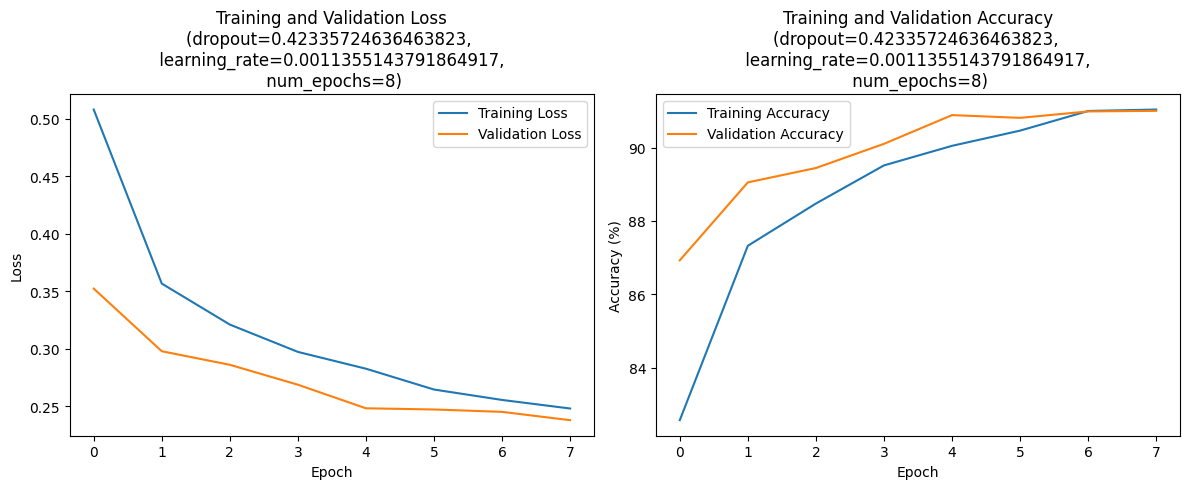

[I 2024-11-21 23:27:40,854] Trial 0 finished with value: 91.0 and parameters: {'dropout': 0.42335724636463823, 'learning_rate': 0.0011355143791864917, 'num_epochs': 8}. Best is trial 0 with value: 91.0.


Loss and accuracy plot saved successfully


Epoch 1/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.90it/s]


Epoch 1/13, Train Loss: 0.6949, Valid Loss: 0.4058, Train Accuracy: 80.07%, Valid Accuracy: 86.58%


Epoch 2/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.90it/s]


Epoch 2/13, Train Loss: 0.4152, Valid Loss: 0.3306, Train Accuracy: 86.37%, Valid Accuracy: 88.01%


Epoch 3/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.71it/s]


Epoch 3/13, Train Loss: 0.3598, Valid Loss: 0.3023, Train Accuracy: 87.58%, Valid Accuracy: 88.96%


Epoch 4/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.07it/s]


Epoch 4/13, Train Loss: 0.3328, Valid Loss: 0.2762, Train Accuracy: 88.46%, Valid Accuracy: 89.66%


Epoch 5/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.80it/s]


Epoch 5/13, Train Loss: 0.3048, Valid Loss: 0.2702, Train Accuracy: 89.29%, Valid Accuracy: 89.96%


Epoch 6/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.02it/s]


Epoch 6/13, Train Loss: 0.2916, Valid Loss: 0.2586, Train Accuracy: 89.54%, Valid Accuracy: 90.38%


Epoch 7/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.69it/s]


Epoch 7/13, Train Loss: 0.2823, Valid Loss: 0.2547, Train Accuracy: 89.95%, Valid Accuracy: 90.51%


Epoch 8/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.16it/s]


Epoch 8/13, Train Loss: 0.2704, Valid Loss: 0.2421, Train Accuracy: 90.36%, Valid Accuracy: 91.03%


Epoch 9/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.72it/s]


Epoch 9/13, Train Loss: 0.2632, Valid Loss: 0.2420, Train Accuracy: 90.63%, Valid Accuracy: 91.29%


Epoch 10/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.18it/s]


Epoch 10/13, Train Loss: 0.2559, Valid Loss: 0.2406, Train Accuracy: 90.87%, Valid Accuracy: 91.24%


Epoch 11/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.82it/s]


Epoch 11/13, Train Loss: 0.2483, Valid Loss: 0.2334, Train Accuracy: 91.09%, Valid Accuracy: 91.42%


Epoch 12/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.97it/s]


Epoch 12/13, Train Loss: 0.2404, Valid Loss: 0.2334, Train Accuracy: 91.32%, Valid Accuracy: 91.45%


Epoch 13/13 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.47it/s]


Epoch 13/13, Train Loss: 0.2364, Valid Loss: 0.2350, Train Accuracy: 91.54%, Valid Accuracy: 91.31%


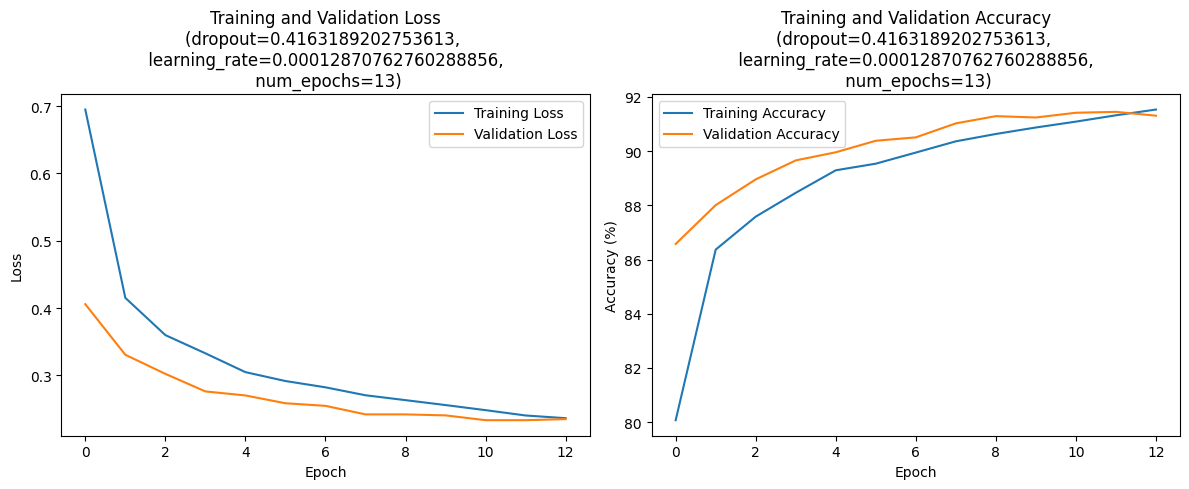

[I 2024-11-21 23:37:10,619] Trial 1 finished with value: 91.45 and parameters: {'dropout': 0.4163189202753613, 'learning_rate': 0.00012870762760288856, 'num_epochs': 13}. Best is trial 1 with value: 91.45.


Loss and accuracy plot saved successfully


Epoch 1/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.88it/s]


Epoch 1/15, Train Loss: 0.5172, Valid Loss: 0.3370, Train Accuracy: 81.59%, Valid Accuracy: 87.78%


Epoch 2/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.90it/s]


Epoch 2/15, Train Loss: 0.3779, Valid Loss: 0.3180, Train Accuracy: 86.69%, Valid Accuracy: 88.08%


Epoch 3/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.61it/s]


Epoch 3/15, Train Loss: 0.3401, Valid Loss: 0.2840, Train Accuracy: 87.85%, Valid Accuracy: 89.68%


Epoch 4/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.88it/s]


Epoch 4/15, Train Loss: 0.3211, Valid Loss: 0.2694, Train Accuracy: 88.63%, Valid Accuracy: 89.97%


Epoch 5/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.84it/s]


Epoch 5/15, Train Loss: 0.3040, Valid Loss: 0.2611, Train Accuracy: 89.27%, Valid Accuracy: 90.32%


Epoch 6/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.89it/s]


Epoch 6/15, Train Loss: 0.2903, Valid Loss: 0.2648, Train Accuracy: 89.60%, Valid Accuracy: 90.36%


Epoch 7/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.31it/s]


Epoch 7/15, Train Loss: 0.2791, Valid Loss: 0.2494, Train Accuracy: 89.99%, Valid Accuracy: 90.97%


Epoch 8/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.83it/s]


Epoch 8/15, Train Loss: 0.2680, Valid Loss: 0.2546, Train Accuracy: 90.33%, Valid Accuracy: 90.57%


Epoch 9/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.68it/s]


Epoch 9/15, Train Loss: 0.2643, Valid Loss: 0.2427, Train Accuracy: 90.34%, Valid Accuracy: 91.04%


Epoch 10/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.42it/s]


Epoch 10/15, Train Loss: 0.2539, Valid Loss: 0.2256, Train Accuracy: 90.79%, Valid Accuracy: 91.54%


Epoch 11/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.14it/s]


Epoch 11/15, Train Loss: 0.2495, Valid Loss: 0.2266, Train Accuracy: 91.23%, Valid Accuracy: 91.59%


Epoch 12/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.60it/s]


Epoch 12/15, Train Loss: 0.2447, Valid Loss: 0.2239, Train Accuracy: 91.22%, Valid Accuracy: 91.70%


Epoch 13/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.04it/s]


Epoch 13/15, Train Loss: 0.2374, Valid Loss: 0.2166, Train Accuracy: 91.53%, Valid Accuracy: 92.11%


Epoch 14/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.34it/s]


Epoch 14/15, Train Loss: 0.2336, Valid Loss: 0.2084, Train Accuracy: 91.71%, Valid Accuracy: 92.20%


Epoch 15/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.44it/s]


Epoch 15/15, Train Loss: 0.2294, Valid Loss: 0.2288, Train Accuracy: 91.81%, Valid Accuracy: 91.57%


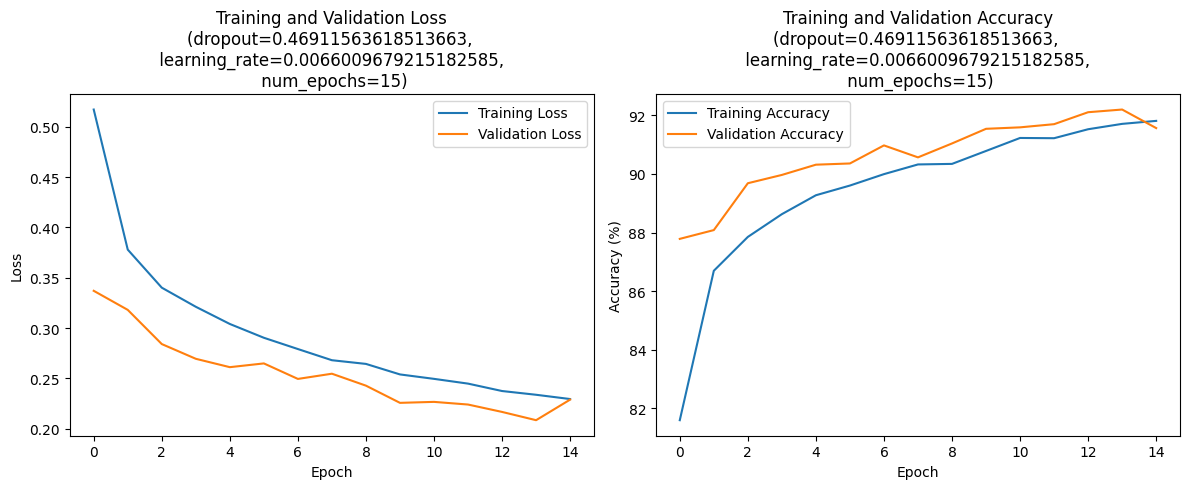

[I 2024-11-21 23:48:03,809] Trial 2 finished with value: 92.2 and parameters: {'dropout': 0.46911563618513663, 'learning_rate': 0.0066009679215182585, 'num_epochs': 15}. Best is trial 2 with value: 92.2.


Loss and accuracy plot saved successfully


Epoch 1/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.91it/s]


Epoch 1/18, Train Loss: 0.7141, Valid Loss: 0.3891, Train Accuracy: 78.42%, Valid Accuracy: 86.19%


Epoch 2/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.66it/s]


Epoch 2/18, Train Loss: 0.4375, Valid Loss: 0.3237, Train Accuracy: 85.44%, Valid Accuracy: 87.97%


Epoch 3/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.26it/s]


Epoch 3/18, Train Loss: 0.3867, Valid Loss: 0.2944, Train Accuracy: 86.92%, Valid Accuracy: 89.29%


Epoch 4/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.19it/s]


Epoch 4/18, Train Loss: 0.3530, Valid Loss: 0.2866, Train Accuracy: 87.78%, Valid Accuracy: 89.48%


Epoch 5/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.65it/s]


Epoch 5/18, Train Loss: 0.3327, Valid Loss: 0.2678, Train Accuracy: 88.44%, Valid Accuracy: 90.33%


Epoch 6/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.79it/s]


Epoch 6/18, Train Loss: 0.3177, Valid Loss: 0.2645, Train Accuracy: 89.19%, Valid Accuracy: 90.19%


Epoch 7/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.13it/s]


Epoch 7/18, Train Loss: 0.3051, Valid Loss: 0.2569, Train Accuracy: 89.38%, Valid Accuracy: 90.39%


Epoch 8/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.89it/s]


Epoch 8/18, Train Loss: 0.2971, Valid Loss: 0.2489, Train Accuracy: 89.60%, Valid Accuracy: 91.03%


Epoch 9/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.02it/s]


Epoch 9/18, Train Loss: 0.2888, Valid Loss: 0.2469, Train Accuracy: 90.00%, Valid Accuracy: 90.92%


Epoch 10/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.29it/s]


Epoch 10/18, Train Loss: 0.2772, Valid Loss: 0.2380, Train Accuracy: 90.28%, Valid Accuracy: 91.28%


Epoch 11/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.26it/s]


Epoch 11/18, Train Loss: 0.2727, Valid Loss: 0.2341, Train Accuracy: 90.49%, Valid Accuracy: 91.38%


Epoch 12/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.75it/s]


Epoch 12/18, Train Loss: 0.2651, Valid Loss: 0.2342, Train Accuracy: 90.80%, Valid Accuracy: 91.28%


Epoch 13/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.68it/s]


Epoch 13/18, Train Loss: 0.2600, Valid Loss: 0.2306, Train Accuracy: 91.03%, Valid Accuracy: 91.83%


Epoch 14/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.92it/s]


Epoch 14/18, Train Loss: 0.2598, Valid Loss: 0.2318, Train Accuracy: 90.97%, Valid Accuracy: 91.58%


Epoch 15/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.90it/s]


Epoch 15/18, Train Loss: 0.2525, Valid Loss: 0.2277, Train Accuracy: 91.15%, Valid Accuracy: 91.48%


Epoch 16/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.54it/s]


Epoch 16/18, Train Loss: 0.2480, Valid Loss: 0.2229, Train Accuracy: 91.28%, Valid Accuracy: 91.77%


Epoch 17/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.10it/s]


Epoch 17/18, Train Loss: 0.2427, Valid Loss: 0.2289, Train Accuracy: 91.55%, Valid Accuracy: 91.52%


Epoch 18/18 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.02it/s]


Epoch 18/18, Train Loss: 0.2420, Valid Loss: 0.2222, Train Accuracy: 91.46%, Valid Accuracy: 91.74%


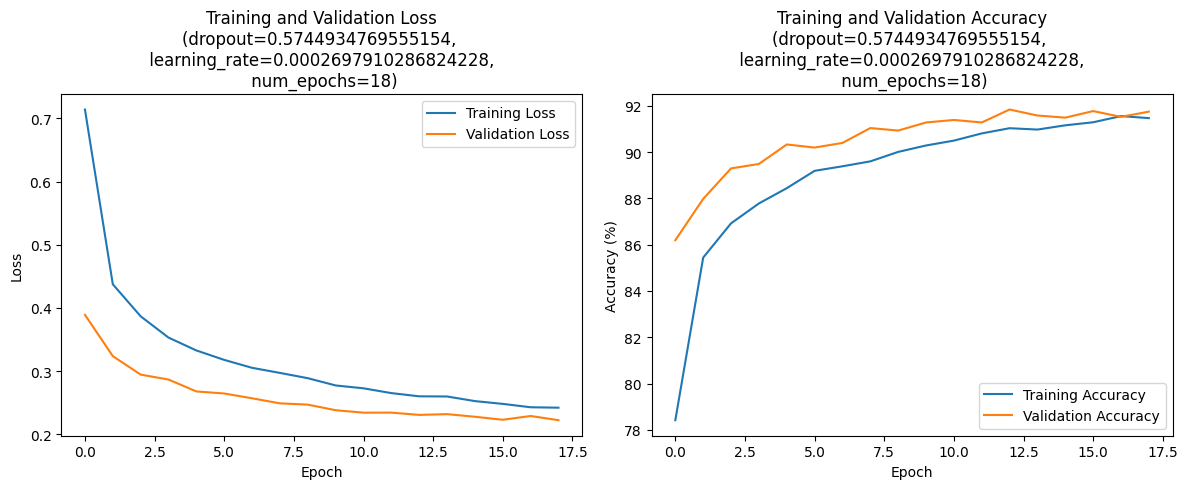

[I 2024-11-22 00:01:08,061] Trial 3 finished with value: 91.83333333333333 and parameters: {'dropout': 0.5744934769555154, 'learning_rate': 0.0002697910286824228, 'num_epochs': 18}. Best is trial 2 with value: 92.2.


Loss and accuracy plot saved successfully


Epoch 1/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.61it/s]


Epoch 1/15, Train Loss: 0.5254, Valid Loss: 0.3452, Train Accuracy: 81.94%, Valid Accuracy: 87.24%


Epoch 2/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.93it/s]


Epoch 2/15, Train Loss: 0.3725, Valid Loss: 0.2984, Train Accuracy: 86.71%, Valid Accuracy: 88.79%


Epoch 3/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.53it/s]


Epoch 3/15, Train Loss: 0.3356, Valid Loss: 0.2775, Train Accuracy: 88.02%, Valid Accuracy: 89.81%


Epoch 4/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.98it/s]


Epoch 4/15, Train Loss: 0.3115, Valid Loss: 0.2864, Train Accuracy: 88.96%, Valid Accuracy: 89.59%


Epoch 5/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.90it/s]


Epoch 5/15, Train Loss: 0.2933, Valid Loss: 0.2554, Train Accuracy: 89.47%, Valid Accuracy: 90.41%


Epoch 6/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.85it/s]


Epoch 6/15, Train Loss: 0.2817, Valid Loss: 0.2519, Train Accuracy: 89.83%, Valid Accuracy: 90.62%


Epoch 7/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.30it/s]


Epoch 7/15, Train Loss: 0.2730, Valid Loss: 0.2359, Train Accuracy: 90.24%, Valid Accuracy: 91.08%


Epoch 8/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.72it/s]


Epoch 8/15, Train Loss: 0.2604, Valid Loss: 0.2387, Train Accuracy: 90.78%, Valid Accuracy: 91.07%


Epoch 9/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.94it/s]


Epoch 9/15, Train Loss: 0.2550, Valid Loss: 0.2231, Train Accuracy: 90.97%, Valid Accuracy: 91.78%


Epoch 10/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.31it/s]


Epoch 10/15, Train Loss: 0.2451, Valid Loss: 0.2271, Train Accuracy: 91.41%, Valid Accuracy: 91.98%


Epoch 11/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.56it/s]


Epoch 11/15, Train Loss: 0.2399, Valid Loss: 0.2212, Train Accuracy: 91.50%, Valid Accuracy: 91.92%


Epoch 12/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.86it/s]


Epoch 12/15, Train Loss: 0.2387, Valid Loss: 0.2211, Train Accuracy: 91.46%, Valid Accuracy: 91.75%


Epoch 13/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.74it/s]


Epoch 13/15, Train Loss: 0.2276, Valid Loss: 0.2198, Train Accuracy: 91.84%, Valid Accuracy: 91.98%


Epoch 14/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.84it/s]


Epoch 14/15, Train Loss: 0.2235, Valid Loss: 0.2105, Train Accuracy: 92.00%, Valid Accuracy: 92.41%


Epoch 15/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.13it/s]


Epoch 15/15, Train Loss: 0.2194, Valid Loss: 0.2094, Train Accuracy: 92.21%, Valid Accuracy: 92.29%


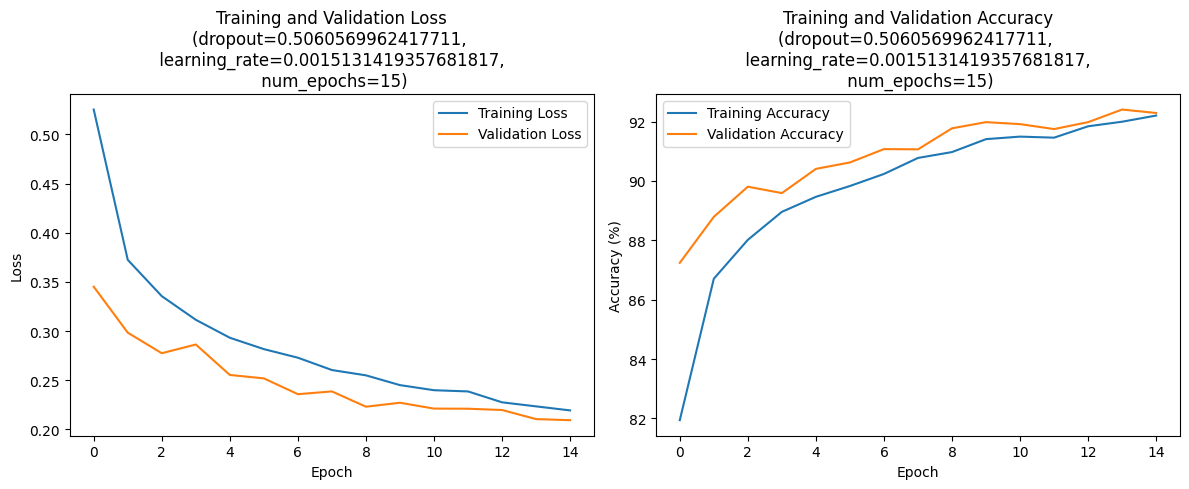

[I 2024-11-22 00:12:02,649] Trial 4 finished with value: 92.40833333333333 and parameters: {'dropout': 0.5060569962417711, 'learning_rate': 0.0015131419357681817, 'num_epochs': 15}. Best is trial 4 with value: 92.40833333333333.


Loss and accuracy plot saved successfully


Epoch 1/6 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.73it/s]


Epoch 1/6, Train Loss: 0.4655, Valid Loss: 0.3480, Train Accuracy: 83.31%, Valid Accuracy: 87.12%


Epoch 2/6 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.98it/s]


Epoch 2/6, Train Loss: 0.3421, Valid Loss: 0.2763, Train Accuracy: 87.54%, Valid Accuracy: 89.83%


Epoch 3/6 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.95it/s]


Epoch 3/6, Train Loss: 0.3077, Valid Loss: 0.2801, Train Accuracy: 88.94%, Valid Accuracy: 89.53%


Epoch 4/6 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.00it/s]


Epoch 4/6, Train Loss: 0.2830, Valid Loss: 0.2636, Train Accuracy: 89.67%, Valid Accuracy: 90.42%


Epoch 5/6 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.00it/s]


Epoch 5/6, Train Loss: 0.2664, Valid Loss: 0.2524, Train Accuracy: 90.39%, Valid Accuracy: 90.85%


Epoch 6/6 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.59it/s]


Epoch 6/6, Train Loss: 0.2521, Valid Loss: 0.2365, Train Accuracy: 90.76%, Valid Accuracy: 91.38%


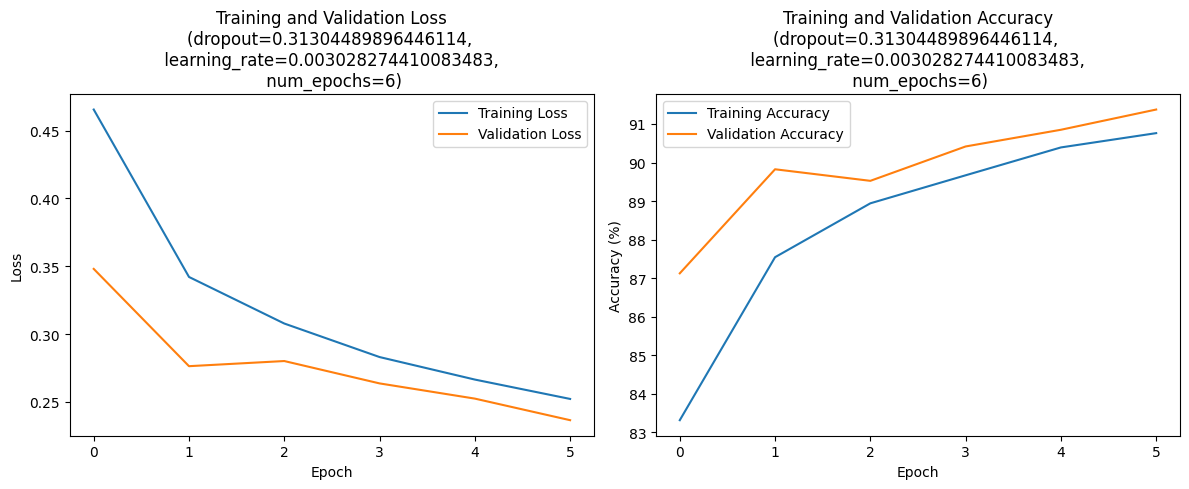

[I 2024-11-22 00:16:24,508] Trial 5 finished with value: 91.375 and parameters: {'dropout': 0.31304489896446114, 'learning_rate': 0.003028274410083483, 'num_epochs': 6}. Best is trial 4 with value: 92.40833333333333.


Loss and accuracy plot saved successfully


Epoch 1/20 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.07it/s]


Epoch 1/20, Train Loss: 0.7104, Valid Loss: 0.3767, Train Accuracy: 78.62%, Valid Accuracy: 86.75%


Epoch 2/20 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.31it/s]


Epoch 2/20, Train Loss: 0.4355, Valid Loss: 0.3279, Train Accuracy: 85.47%, Valid Accuracy: 88.16%


Epoch 3/20 - Validation: 100%|██████████| 188/188 [00:09<00:00, 20.22it/s]


Epoch 3/20, Train Loss: 0.3851, Valid Loss: 0.2991, Train Accuracy: 87.00%, Valid Accuracy: 89.01%


Epoch 4/20 - Validation: 100%|██████████| 188/188 [00:09<00:00, 19.85it/s]


Epoch 4/20, Train Loss: 0.3494, Valid Loss: 0.2842, Train Accuracy: 88.01%, Valid Accuracy: 89.36%


Epoch 5/20 - Validation: 100%|██████████| 188/188 [00:09<00:00, 19.56it/s]


Epoch 5/20, Train Loss: 0.3355, Valid Loss: 0.2672, Train Accuracy: 88.38%, Valid Accuracy: 90.04%


Epoch 6/20 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.10it/s]


Epoch 6/20, Train Loss: 0.3198, Valid Loss: 0.2594, Train Accuracy: 88.94%, Valid Accuracy: 90.42%


Epoch 7/20 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.66it/s]


Epoch 7/20, Train Loss: 0.3082, Valid Loss: 0.2625, Train Accuracy: 89.30%, Valid Accuracy: 90.30%


Epoch 8/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.58it/s]


Epoch 8/20, Train Loss: 0.2984, Valid Loss: 0.2466, Train Accuracy: 89.61%, Valid Accuracy: 90.75%


Epoch 9/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.45it/s]


Epoch 9/20, Train Loss: 0.2870, Valid Loss: 0.2451, Train Accuracy: 89.86%, Valid Accuracy: 90.83%


Epoch 10/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.38it/s]


Epoch 10/20, Train Loss: 0.2799, Valid Loss: 0.2490, Train Accuracy: 90.35%, Valid Accuracy: 90.91%


Epoch 11/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.38it/s]


Epoch 11/20, Train Loss: 0.2722, Valid Loss: 0.2336, Train Accuracy: 90.49%, Valid Accuracy: 91.10%


Epoch 12/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.41it/s]


Epoch 12/20, Train Loss: 0.2675, Valid Loss: 0.2316, Train Accuracy: 90.57%, Valid Accuracy: 91.47%


Epoch 13/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.54it/s]


Epoch 13/20, Train Loss: 0.2604, Valid Loss: 0.2360, Train Accuracy: 90.89%, Valid Accuracy: 90.96%


Epoch 14/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.48it/s]


Epoch 14/20, Train Loss: 0.2517, Valid Loss: 0.2287, Train Accuracy: 91.18%, Valid Accuracy: 91.62%


Epoch 15/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.49it/s]


Epoch 15/20, Train Loss: 0.2508, Valid Loss: 0.2260, Train Accuracy: 91.24%, Valid Accuracy: 91.74%


Epoch 16/20 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.88it/s]


Epoch 16/20, Train Loss: 0.2471, Valid Loss: 0.2291, Train Accuracy: 91.31%, Valid Accuracy: 91.65%


Epoch 17/20 - Validation: 100%|██████████| 188/188 [00:11<00:00, 17.05it/s]


Epoch 17/20, Train Loss: 0.2444, Valid Loss: 0.2216, Train Accuracy: 91.28%, Valid Accuracy: 91.82%


Epoch 18/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.13it/s]


Epoch 18/20, Train Loss: 0.2397, Valid Loss: 0.2270, Train Accuracy: 91.58%, Valid Accuracy: 91.54%


Epoch 19/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.26it/s]


Epoch 19/20, Train Loss: 0.2324, Valid Loss: 0.2149, Train Accuracy: 91.82%, Valid Accuracy: 92.19%


Epoch 20/20 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.22it/s]


Epoch 20/20, Train Loss: 0.2330, Valid Loss: 0.2138, Train Accuracy: 91.68%, Valid Accuracy: 92.15%


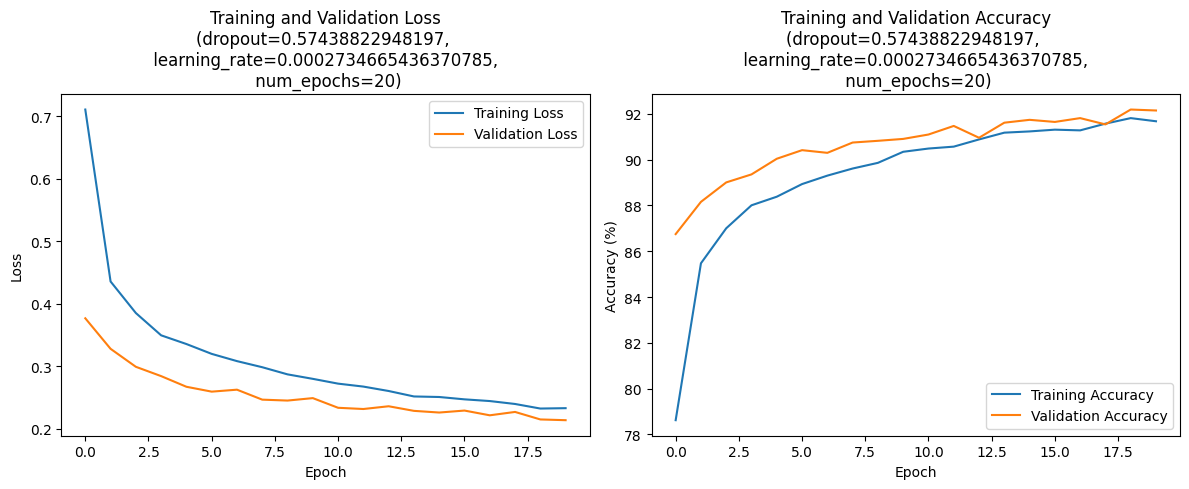

[I 2024-11-22 00:34:23,458] Trial 6 finished with value: 92.19166666666666 and parameters: {'dropout': 0.57438822948197, 'learning_rate': 0.0002734665436370785, 'num_epochs': 20}. Best is trial 4 with value: 92.40833333333333.


Loss and accuracy plot saved successfully


Epoch 1/9 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.29it/s]


Epoch 1/9, Train Loss: 0.5483, Valid Loss: 0.3694, Train Accuracy: 82.38%, Valid Accuracy: 86.90%


Epoch 2/9 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.88it/s]


Epoch 2/9, Train Loss: 0.3653, Valid Loss: 0.3008, Train Accuracy: 87.13%, Valid Accuracy: 88.73%


Epoch 3/9 - Validation: 100%|██████████| 188/188 [00:08<00:00, 23.08it/s]


Epoch 3/9, Train Loss: 0.3253, Valid Loss: 0.2812, Train Accuracy: 88.37%, Valid Accuracy: 89.97%


Epoch 4/9 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.79it/s]


Epoch 4/9, Train Loss: 0.2992, Valid Loss: 0.2706, Train Accuracy: 89.21%, Valid Accuracy: 89.86%


Epoch 5/9 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.43it/s]


Epoch 5/9, Train Loss: 0.2833, Valid Loss: 0.2636, Train Accuracy: 89.84%, Valid Accuracy: 90.01%


Epoch 6/9 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.63it/s]


Epoch 6/9, Train Loss: 0.2704, Valid Loss: 0.2494, Train Accuracy: 90.44%, Valid Accuracy: 90.72%


Epoch 7/9 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.26it/s]


Epoch 7/9, Train Loss: 0.2609, Valid Loss: 0.2494, Train Accuracy: 90.64%, Valid Accuracy: 90.88%


Epoch 8/9 - Validation: 100%|██████████| 188/188 [00:08<00:00, 20.97it/s]


Epoch 8/9, Train Loss: 0.2528, Valid Loss: 0.2425, Train Accuracy: 90.92%, Valid Accuracy: 91.09%


Epoch 9/9 - Validation: 100%|██████████| 188/188 [00:09<00:00, 20.83it/s]


Epoch 9/9, Train Loss: 0.2438, Valid Loss: 0.2371, Train Accuracy: 91.21%, Valid Accuracy: 91.22%


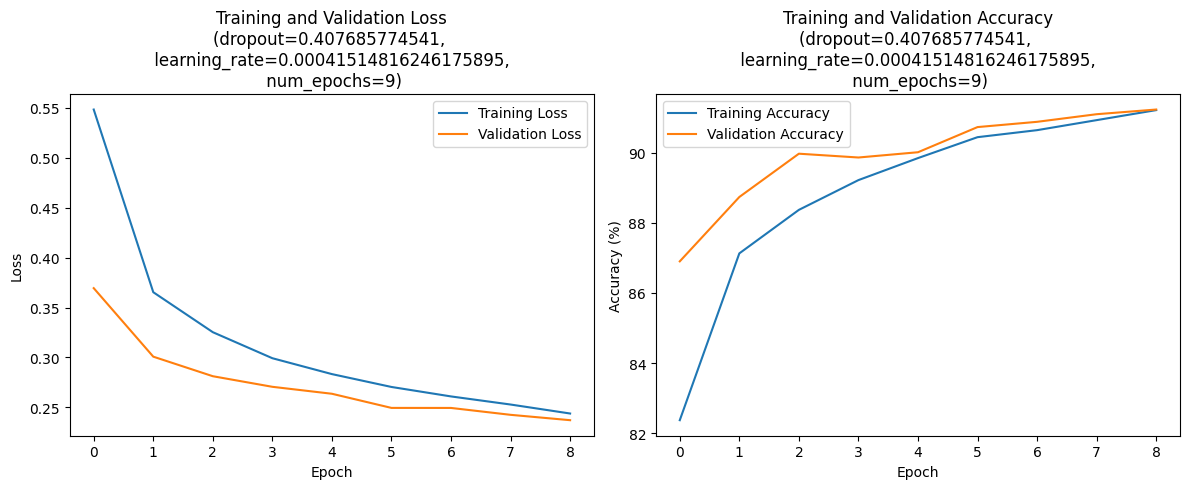

[I 2024-11-22 00:41:30,274] Trial 7 finished with value: 91.225 and parameters: {'dropout': 0.407685774541, 'learning_rate': 0.00041514816246175895, 'num_epochs': 9}. Best is trial 4 with value: 92.40833333333333.


Loss and accuracy plot saved successfully


Epoch 1/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.31it/s]


Epoch 1/15, Train Loss: 0.4963, Valid Loss: 0.3250, Train Accuracy: 82.83%, Valid Accuracy: 87.86%


Epoch 2/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.69it/s]


Epoch 2/15, Train Loss: 0.3483, Valid Loss: 0.2895, Train Accuracy: 87.71%, Valid Accuracy: 88.99%


Epoch 3/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.86it/s]


Epoch 3/15, Train Loss: 0.3164, Valid Loss: 0.2827, Train Accuracy: 88.71%, Valid Accuracy: 89.49%


Epoch 4/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.90it/s]


Epoch 4/15, Train Loss: 0.2902, Valid Loss: 0.2553, Train Accuracy: 89.59%, Valid Accuracy: 90.52%


Epoch 5/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.05it/s]


Epoch 5/15, Train Loss: 0.2722, Valid Loss: 0.2466, Train Accuracy: 90.17%, Valid Accuracy: 90.85%


Epoch 6/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.03it/s]


Epoch 6/15, Train Loss: 0.2602, Valid Loss: 0.2504, Train Accuracy: 90.65%, Valid Accuracy: 90.55%


Epoch 7/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.45it/s]


Epoch 7/15, Train Loss: 0.2552, Valid Loss: 0.2363, Train Accuracy: 90.73%, Valid Accuracy: 91.28%


Epoch 8/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.28it/s]


Epoch 8/15, Train Loss: 0.2441, Valid Loss: 0.2311, Train Accuracy: 91.24%, Valid Accuracy: 91.48%


Epoch 9/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.98it/s]


Epoch 9/15, Train Loss: 0.2354, Valid Loss: 0.2170, Train Accuracy: 91.45%, Valid Accuracy: 91.90%


Epoch 10/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.50it/s]


Epoch 10/15, Train Loss: 0.2287, Valid Loss: 0.2184, Train Accuracy: 91.66%, Valid Accuracy: 92.14%


Epoch 11/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.83it/s]


Epoch 11/15, Train Loss: 0.2193, Valid Loss: 0.2213, Train Accuracy: 92.03%, Valid Accuracy: 91.72%


Epoch 12/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.97it/s]


Epoch 12/15, Train Loss: 0.2156, Valid Loss: 0.2156, Train Accuracy: 92.04%, Valid Accuracy: 92.27%


Epoch 13/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.59it/s]


Epoch 13/15, Train Loss: 0.2071, Valid Loss: 0.2090, Train Accuracy: 92.50%, Valid Accuracy: 92.45%


Epoch 14/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.47it/s]


Epoch 14/15, Train Loss: 0.2024, Valid Loss: 0.2100, Train Accuracy: 92.63%, Valid Accuracy: 92.32%


Epoch 15/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.51it/s]


Epoch 15/15, Train Loss: 0.1993, Valid Loss: 0.2041, Train Accuracy: 92.82%, Valid Accuracy: 92.78%


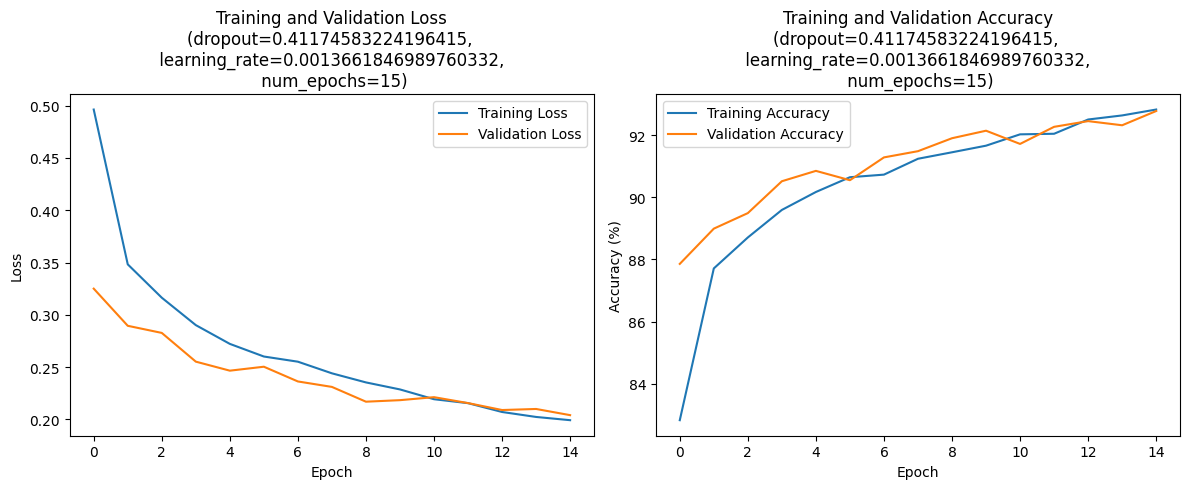

[I 2024-11-22 00:52:47,885] Trial 8 finished with value: 92.775 and parameters: {'dropout': 0.41174583224196415, 'learning_rate': 0.0013661846989760332, 'num_epochs': 15}. Best is trial 8 with value: 92.775.


Loss and accuracy plot saved successfully


Epoch 1/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.14it/s]


Epoch 1/10, Train Loss: 0.4867, Valid Loss: 0.3347, Train Accuracy: 83.73%, Valid Accuracy: 87.62%


Epoch 2/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.74it/s]


Epoch 2/10, Train Loss: 0.3374, Valid Loss: 0.2952, Train Accuracy: 87.91%, Valid Accuracy: 89.01%


Epoch 3/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.35it/s]


Epoch 3/10, Train Loss: 0.3015, Valid Loss: 0.2843, Train Accuracy: 89.24%, Valid Accuracy: 89.38%


Epoch 4/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.40it/s]


Epoch 4/10, Train Loss: 0.2783, Valid Loss: 0.2704, Train Accuracy: 89.89%, Valid Accuracy: 89.71%


Epoch 5/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.74it/s]


Epoch 5/10, Train Loss: 0.2657, Valid Loss: 0.2492, Train Accuracy: 90.47%, Valid Accuracy: 90.74%


Epoch 6/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.11it/s]


Epoch 6/10, Train Loss: 0.2508, Valid Loss: 0.2459, Train Accuracy: 90.98%, Valid Accuracy: 90.96%


Epoch 7/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.60it/s]


Epoch 7/10, Train Loss: 0.2405, Valid Loss: 0.2379, Train Accuracy: 91.31%, Valid Accuracy: 91.42%


Epoch 8/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.07it/s]


Epoch 8/10, Train Loss: 0.2307, Valid Loss: 0.2270, Train Accuracy: 91.50%, Valid Accuracy: 91.93%


Epoch 9/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.32it/s]


Epoch 9/10, Train Loss: 0.2197, Valid Loss: 0.2266, Train Accuracy: 91.92%, Valid Accuracy: 91.64%


Epoch 10/10 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.95it/s]


Epoch 10/10, Train Loss: 0.2127, Valid Loss: 0.2301, Train Accuracy: 92.27%, Valid Accuracy: 91.58%


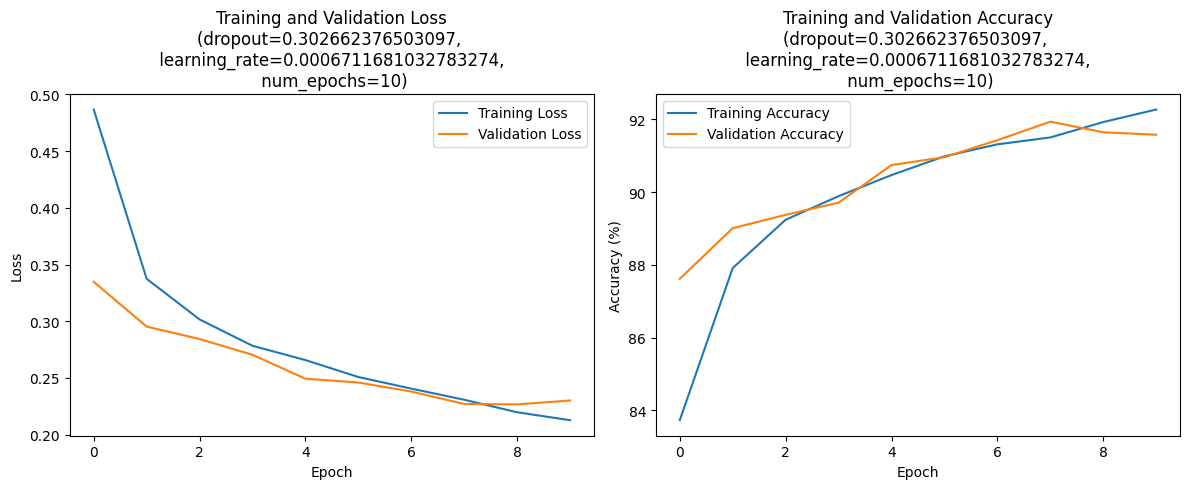

[I 2024-11-22 01:00:12,820] Trial 9 finished with value: 91.93333333333334 and parameters: {'dropout': 0.302662376503097, 'learning_rate': 0.0006711681032783274, 'num_epochs': 10}. Best is trial 8 with value: 92.775.


Loss and accuracy plot saved successfully
Best parameters found:
{'dropout': 0.41174583224196415, 'learning_rate': 0.0013661846989760332, 'num_epochs': 15}


Epoch 1/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 22.61it/s]


Epoch 1/15, Train Loss: 0.4909, Valid Loss: 0.3287, Train Accuracy: 83.13%, Valid Accuracy: 87.64%


Epoch 2/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 20.95it/s]


Epoch 2/15, Train Loss: 0.3529, Valid Loss: 0.2880, Train Accuracy: 87.42%, Valid Accuracy: 89.53%


Epoch 3/15 - Validation: 100%|██████████| 188/188 [00:09<00:00, 19.34it/s]


Epoch 3/15, Train Loss: 0.3126, Valid Loss: 0.2758, Train Accuracy: 88.75%, Valid Accuracy: 90.08%


Epoch 4/15 - Validation: 100%|██████████| 188/188 [00:09<00:00, 19.17it/s]


Epoch 4/15, Train Loss: 0.2932, Valid Loss: 0.2592, Train Accuracy: 89.47%, Valid Accuracy: 90.39%


Epoch 5/15 - Validation: 100%|██████████| 188/188 [00:09<00:00, 19.81it/s]


Epoch 5/15, Train Loss: 0.2795, Valid Loss: 0.2426, Train Accuracy: 90.05%, Valid Accuracy: 91.09%


Epoch 6/15 - Validation: 100%|██████████| 188/188 [00:09<00:00, 20.22it/s]


Epoch 6/15, Train Loss: 0.2653, Valid Loss: 0.2374, Train Accuracy: 90.45%, Valid Accuracy: 91.31%


Epoch 7/15 - Validation: 100%|██████████| 188/188 [00:08<00:00, 21.47it/s]


Epoch 7/15, Train Loss: 0.2557, Valid Loss: 0.2311, Train Accuracy: 90.81%, Valid Accuracy: 91.39%


Epoch 8/15 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.36it/s]


Epoch 8/15, Train Loss: 0.2452, Valid Loss: 0.2355, Train Accuracy: 91.12%, Valid Accuracy: 91.33%


Epoch 9/15 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.38it/s]


Epoch 9/15, Train Loss: 0.2375, Valid Loss: 0.2253, Train Accuracy: 91.50%, Valid Accuracy: 91.77%


Epoch 10/15 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.31it/s]


Epoch 10/15, Train Loss: 0.2289, Valid Loss: 0.2181, Train Accuracy: 91.63%, Valid Accuracy: 91.93%


Epoch 11/15 - Validation: 100%|██████████| 188/188 [00:11<00:00, 16.73it/s]


Epoch 11/15, Train Loss: 0.2242, Valid Loss: 0.2154, Train Accuracy: 91.82%, Valid Accuracy: 92.27%


Epoch 12/15 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.34it/s]


Epoch 12/15, Train Loss: 0.2152, Valid Loss: 0.2182, Train Accuracy: 92.10%, Valid Accuracy: 92.27%


Epoch 13/15 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.28it/s]


Epoch 13/15, Train Loss: 0.2098, Valid Loss: 0.2134, Train Accuracy: 92.46%, Valid Accuracy: 92.33%


Epoch 14/15 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.49it/s]


Epoch 14/15, Train Loss: 0.2071, Valid Loss: 0.2165, Train Accuracy: 92.46%, Valid Accuracy: 92.24%


Epoch 15/15 - Validation: 100%|██████████| 188/188 [00:10<00:00, 17.38it/s]


Epoch 15/15, Train Loss: 0.2007, Valid Loss: 0.2021, Train Accuracy: 92.71%, Valid Accuracy: 92.51%


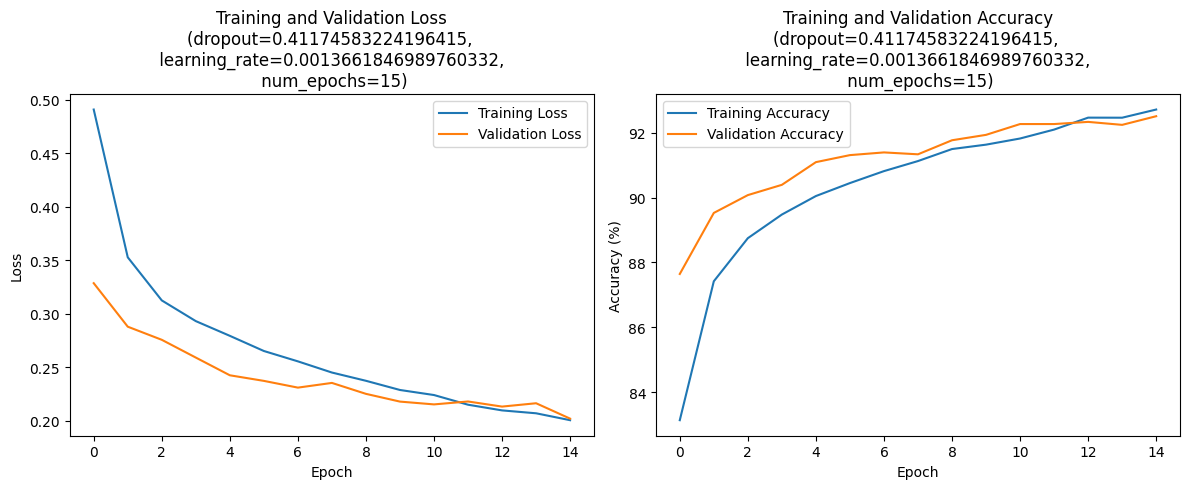

Loss and accuracy plot saved successfully


RuntimeError: Parent directory ./model does not exist.

In [31]:
try:
    state_dict = torch.load(model_path, map_location=device, weights_only=True)
    best_model.load_state_dict(state_dict)
    best_model.eval()
    # extract the best parameters
    best_params = {
        'dropout': best_model.dropout_rate,
        'learning_rate': best_model.learning_rate,
        'num_epochs': best_model.num_epochs
    }
except FileNotFoundError:
    # Create a study and optimize
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)

    # Print best parameters
    print("Best parameters found:")
    print(study.best_params)

    # Evaluate on the testing set with the best model
    best_params = study.best_params
    best_model = SimpleCNNImage(dropout=best_params['dropout']).to(device)
    optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
    train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
        best_model, criterion, optimizer, trainloader, valloader, best_params['num_epochs'], best_params['dropout'], best_params['learning_rate']
    )

    # Save the model state dict
    model_path = "./model/best_model_state.pth"
    torch.save(best_model.state_dict(), model_path)
    print(f"Model state dict saved to {model_path}")

In [34]:
print(best_params)
model_path = "./model/best_model_state.pth"
torch.save(best_model.state_dict(), model_path)
print(f"Model state dict saved to {model_path}")

{'dropout': 0.41174583224196415, 'learning_rate': 0.0013661846989760332, 'num_epochs': 15}
Model state dict saved to ./model/best_model_state.pth


In [ ]:
# Plot the confusion matrix, f1 score, and classification report

    def evaluate_model(model, loader):

        if loader == valloader:
            print("Evaluating on the validation set")
            flag = "val"
        elif loader == testloader:
            print("Evaluating on the test set")
            flag = "test"
            test_loss = 0
            correct_test = 0
            total_test = 0

        best_model.eval()
        y_true = []
        y_pred = []
        misclassified_images = []
        true_labels = []
        predicted_labels = []

        with torch.no_grad():
            for images, labels in tqdm(loader, desc="Testing"):
                images, labels = images.to(device), labels.to(device)
                _, outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

                # Find misclassified images
                misclassified_mask = predicted != labels
                misclassified_images.extend(images[misclassified_mask])
                true_labels.extend(labels[misclassified_mask])
                predicted_labels.extend(predicted[misclassified_mask])

                if flag == "test":
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    total_test += labels.size(0)
                    correct_test += (predicted == labels).sum().item()

        if flag == "test":
            test_accuracy = 100 * correct_test / total_test
            print(f"Test Loss: {test_loss / len(testloader):.4f}, Test Accuracy: {test_accuracy:.2f}%")

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        return misclassified_images, true_labels, predicted_labels, y_true, y_pred

    # Evaluate the model on the validation set
    misclassified_images_val, true_labels_val, predicted_labels_val, y_true_val, y_pred_val = evaluate_model(best_model, valloader)

    # Evaluate the model on the test set
    misclassified_images_test, true_labels_test, predicted_labels_test, y_true_test, y_pred_test = evaluate_model(best_model, testloader)

    # %%
    # Define the number of folds
    k_folds = 5

    # Set up KFold
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    # Store results for each fold
    fold_train_losses = []
    fold_valid_losses = []
    fold_train_accuracies = []
    fold_valid_accuracies = []

    # Extract best parameters of the model
    dropout = best_params['dropout']
    learning_rate = best_params['learning_rate']
    num_epochs = best_params['num_epochs']

    # Loop over each fold
    for fold, (train_idx, val_idx) in enumerate(kf.split(trainset)):
        print(f'Fold {fold + 1}/{k_folds}')
        
        # Create samplers for training and validation
        train_sampler = SubsetRandomSampler(train_idx)
        val_sampler = SubsetRandomSampler(val_idx)

        # Create data loaders with samplers
        trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
        valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)

        # Initialize model, criterion, and optimizer
        model = SimpleCNNImage(dropout=dropout)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # Train the model for this fold
        train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
            model, criterion, optimizer, trainloader, valloader, num_epochs=num_epochs
        )

        # Store the results
        fold_train_losses.append(train_losses)
        fold_valid_losses.append(valid_losses)
        fold_train_accuracies.append(train_accuracies)
        fold_valid_accuracies.append(valid_accuracies)

    # Calculate the average performance across all folds
    avg_train_losses = np.mean(fold_train_losses, axis=0)
    avg_valid_losses = np.mean(fold_valid_losses, axis=0)
    avg_train_accuracies = np.mean(fold_train_accuracies, axis=0)
    avg_valid_accuracies = np.mean(fold_valid_accuracies, axis=0)

    # Plotting average training and validation metrics across all folds
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(avg_train_losses, label='Training Loss')
    plt.plot(avg_valid_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training and Validation Loss (Across Folds)')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(avg_train_accuracies, label='Training Accuracy')
    plt.plot(avg_valid_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Average Training and Validation Accuracy (Across Folds)')
    plt.legend()

    plt.tight_layout()
    plt.show()
    plt.savefig('./Images/average_loss_accuracy_plot_across_5_folds.png')
    print("Average loss and accuracy plot saved successfully")
    plt.close()

    # %%
    # Plot confusion matrix, f1 score, and classification report
    def plot_results(y_true, y_pred, name):
        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=text_labels, yticklabels=text_labels)
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix' + f" ({name})")
        plt.show()
        plt.savefig(f'./Images/confusion_matrix_{name}.png')
        print(f"Confusion matrix saved successfully ({name})")
        plt.close()

        # F1 score
        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f"F1 Score: {f1:.4f}" + f" ({name})")

        # Classification report
        report = classification_report(y_true, y_pred, target_names=text_labels)
        print("Classification Report:" + f" ({name})")
        print(report)

        # Accuracy
        accuracy = accuracy_score(y_true, y_pred)
        print(f"Accuracy: {accuracy:.4f}" + f" ({name})")

        print("\nMost Common Misclassifications" + f" ({name})")
        conf_df = pd.DataFrame(cm, index=text_labels, columns=text_labels)
        misclassified_pairs = conf_df.stack().reset_index()
        misclassified_pairs.columns = ["True Label", "Predicted Label", "Count"]
        misclassified_pairs = misclassified_pairs[misclassified_pairs["True Label"] != misclassified_pairs["Predicted Label"]]
        misclassified_pairs = misclassified_pairs.sort_values("Count", ascending=False)
        misclassified_pairs = misclassified_pairs.reset_index(drop=True)

        print(misclassified_pairs.head(10))
        print()    
        print()

    # Plot the results for the validation set
    plot_results(y_true_val, y_pred_val, "Validation")

    # Plot the results for the test set
    plot_results(y_true_test, y_pred_test, "Test")

    # %%
    # Function to visualize some of the misclassified images
    def visualize_misclassified_images(misclassified_images, true_labels, predicted_labels, class_names, num_images=5, name=""):
        print(f"Misclassified images ({name})")
        plt.figure(figsize=(10, 10))
        for i in range(min(num_images, len(misclassified_images))):
            image = misclassified_images[i].cpu().numpy().squeeze()
            true_label = class_names[true_labels[i].cpu().item()]
            predicted_label = class_names[predicted_labels[i].cpu().item()]
            
            plt.subplot(1, num_images, i + 1)
            plt.imshow(image, cmap='gray')
            plt.title(f'True: {true_label}\nPred: {predicted_label}')
            plt.axis('off')
        plt.show()
        plt.savefig(f'./Images/misclassified_images_{name}.png')
        print(f"Misclassified images saved successfully ({name})")
        plt.close()

    # Define class names for FashionMNIST
    class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    # Visualize some of the misclassified images
    visualize_misclassified_images(misclassified_images_val, true_labels_val, predicted_labels_val, class_names, num_images=5, name="Validation")
    visualize_misclassified_images(misclassified_images_test, true_labels_test, predicted_labels_val, class_names, num_images=5, name="Test")

**CLIP**

In [ ]:
model_clip, preprocess = clip.load("ViT-B/32", download_root="/scratch/user/jdr/ECEN_758/model/", device=device)

In [ ]:
#  Define class names for FashionMNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

all_preds = []
all_labels = []

text_prompts = [f"a photo of a {label}" for label in class_names]
text_inputs = clip.tokenize(text_prompts).to(device)

with torch.no_grad():
    for images, labels in tqdm(testloader_clip, desc="Zero-Shot Classification with CLIP"):

        images = images.to(device)
        labels = labels.to(device)
        
        image_features = model_clip.encode_image(images)
        text_features = model_clip.encode_text(text_inputs)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)

        # Get the prediction
        values, indices = similarity.topk(1, dim=-1)  # Get the most likely label (top-1)
        # Since indices is a tensor, convert to CPU and NumPy array
        all_preds.extend(indices.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Print unique classes in predictions and labels
print("Unique predicted labels:", np.unique(all_preds))
print("Unique true labels:", np.unique(all_labels))

# Plot confusion matrix, f1 score, and classification report
def plot_results_clip(y_true, y_pred, name):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=text_labels, yticklabels=text_labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix' + f" ({name})")
    plt.show()
    plt.savefig(f'./Images/confusion_matrix_{name}.png')
    print(f"Confusion matrix saved successfully ({name})")
    plt.close()

    # F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score: {f1:.4f}" + f" ({name})")

    # Classification report
    report = classification_report(y_true, y_pred, target_names=text_labels)
    print("Classification Report:" + f" ({name})")
    print(report)

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}" + f" ({name})")

    print("\nMost Common Misclassifications" + f" ({name})")
    conf_df = pd.DataFrame(cm, index=text_labels, columns=text_labels)
    misclassified_pairs = conf_df.stack().reset_index()
    misclassified_pairs.columns = ["True Label", "Predicted Label", "Count"]
    misclassified_pairs = misclassified_pairs[misclassified_pairs["True Label"] != misclassified_pairs["Predicted Label"]]
    misclassified_pairs = misclassified_pairs.sort_values("Count", ascending=False)
    misclassified_pairs = misclassified_pairs.reset_index(drop=True)

    print(misclassified_pairs.head(10))

In [ ]:
plot_results_clip(all_labels, all_preds, "Zero-Shot Classification with CLIP")

In [ ]:
# Define the transform to convert a tensor to a PIL image
to_pil = transforms.ToPILImage()

def text_to_image_in_memory(text_query, loader, preprocess):
    best_match_index = None
    best_similarity = -float('inf')

    with torch.no_grad():
        # Track the absolute index of the best matching image
        absolute_image_index = 0

        for idx, (images, labels) in enumerate(tqdm(loader, desc="Text to Image Matching")):
            batch_size = images.size(0)
            
            for i in range(batch_size):
                # Convert the image tensor to a PIL image
                image_pil = to_pil(images[i])
                
                # Preprocess individual images and add a batch dimension
                image = preprocess(image_pil).unsqueeze(0).to(device)

                # Encode image and text features
                image_features = model_clip.encode_image(image)
                text_input = clip.tokenize([text_query]).to(device)
                text_features = model_clip.encode_text(text_input)

                # Normalize the features
                image_features /= image_features.norm(dim=-1, keepdim=True)
                text_features /= text_features.norm(dim=-1, keepdim=True)

                # Calculate similarity between the text query and image features
                similarity = (100.0 * image_features @ text_features.T).squeeze()

                # If this image is the best match so far, update the tracking variables
                if similarity > best_similarity:
                    best_similarity = similarity
                    best_match_index = absolute_image_index  # Store the absolute index of the best matching image

                # Update absolute index
                absolute_image_index += 1

    return best_match_index, best_similarity

In [ ]:
# Example multiple text query
text_queries = ["a photo of a sneaker", "a photo of a dress", "a photo of a t-shirt", "a photo of a bag", "a photo of a dog", "a photo of a cat"]
for text_query in text_queries:
    # After calling the function, use the best_match_index to reference the image
    best_match_index, best_similarity = text_to_image_in_memory(text_query, testloader_clip, preprocess)

    # Use the test dataset to retrieve the matched image and display it
    best_image, best_label = testset_clip[best_match_index]  # Get the best-matching image from the dataset
    best_image_pil = transforms.ToPILImage()(best_image)  # Convert tensor to PIL image

    # Output the result
    print(f"Best match index: {best_match_index}, Similarity: {best_similarity:.4f}")
    # save the best image
    plt.figure(figsize=(4, 4))
    plt.imshow(best_image_pil)
    plt.axis('off')  # Turn off axes for a cleaner look
    plt.title(f"Text Query: {text_query} Best match: {class_names[best_label]} with similarity {best_similarity:.4f}")
    plt.show()
    plt.savefig(f'./Images/text_to_image_{text_query.replace(" ", "_").replace("/", "_")}.png')
    print("text_to_image_saved_successfully")